# <center>A4. Customer Service Query Classification</center>

<h2><center>Contents Legend</center></h2>

<center><a href= "#1.-Dependencies">Dependencies</a></center>
<center><a href= "#2.-Pre-processing-Dataset">Pre-processing Dataset</a></center>
<center><a href= "#3.-Cleaning">Cleaning</a></center>
<center><a href= "#4.-Data-Split">Data Split</a></center>
<center><a href= "#5.-TFIDF-Vectorization-of-BOW">TFIDF Vectorization of BOW</a></center>
<center><a href= "#6.-NaiveBayes-Classifier">NaiveBayes Classifier</a></center>
<center><a href= "#7.-Random-Forest">Random Forest</a></center>
<center><a href= "#8.-Neural-Network-Classifier">Neural Network Classifier</a></center>
<center><a href= "#9.-Out-of-Sample-Test">Out of Sample Test</a></center>

## 1. Dependencies

In [7]:
import pandas as pd
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 2. Pre-processing Dataset

In [8]:
# importing csv into a dataframe
df = pd.read_csv("Customer_Service_Questions_Multiclass.csv")
print("Dataframe shape :", df.shape)
df.head(3)

Dataframe shape : (5000, 2)


,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping


In [9]:
#let's explore Target variable 'topic'
#set(df['topic'])
df['topic'].value_counts()

Product Specifications    839
Product Availability      833
Product Comparison        806
Shipping                  799
Returns & Refunds         768
Sales/Promotions          505
Omnichannel               450
Name: topic, dtype: int64

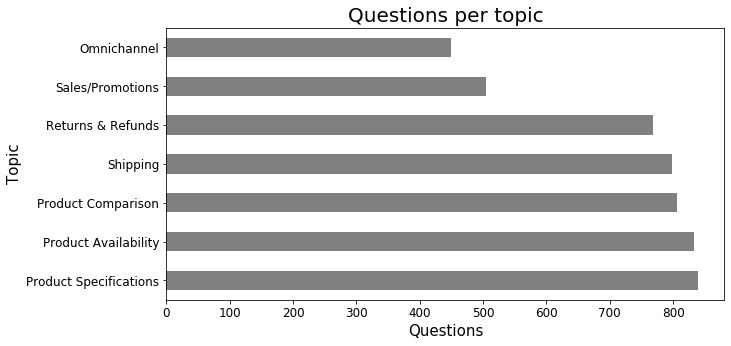

In [10]:
xyz = df['topic'].value_counts().plot(kind='barh', figsize=(10,5), color="grey", fontsize=12)
xyz.set_title("Questions per topic", fontsize=20)
xyz.set_ylabel("Topic", fontsize=15);
xyz.set_xlabel("Questions", fontsize=15);

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 3. Cleaning

In [11]:
lemmatizer = WordNetLemmatizer()
clean_question = []
for q in df['question']:
    que = regexp_tokenize(q.lower(), r'[A-Za-z]+')
    que = [w for w in que if len(w)>1 and w not in stopwords.words('english')]
    que = [lemmatizer.lemmatize(w) for w in que]
    clean_question.append(' '.join(que))

In [12]:
df['clean_question'] = clean_question
df.head(1)

,question,topic,clean_question
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,hi sign email list select get email exclusivel...


<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 4. Data Split

In [13]:
# Splitting data into train and test 
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df['clean_question'],df['topic'],stratify=df['topic'], test_size=0.2, random_state=42)

In [14]:
#converting 'topic' column into categorical using encoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

train_y = enc.fit_transform(train_y)
test_y = enc.transform(test_y)

topics = enc.inverse_transform(np.unique(train_y))

In [15]:
print('train_y after encoding : ',np.unique(train_y))
print()
print('cross checking by decoding train_y : ',topics)

train_y after encoding :  [0 1 2 3 4 5 6]

cross checking by decoding train_y :  ['Omnichannel' 'Product Availability' 'Product Comparison'
 'Product Specifications' 'Returns & Refunds' 'Sales/Promotions'
 'Shipping']


<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 5. TFIDF Vectorization of BOW

The rationale behind using TFIDS is to weigh co-occuraning words with n-gram in each document

In [16]:
#TFIDF vectorizer with n-gram
from sklearn.feature_extraction.text import TfidfVectorizer
    
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',ngram_range=(2,3))
tfidf_vect.fit(df['clean_question'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

In [17]:
xtest_tfidf

<1000x51284 sparse matrix of type '<class 'numpy.float64'>'
	with 25272 stored elements in Compressed Sparse Row format>

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 6. NaiveBayes Classifier

In [18]:
#grid search for best hyperparameters
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False], 
}
clf = GridSearchCV(MultinomialNB(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

C:\Users\samrat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.9115
Best Params:  {'alpha': 0.5, 'fit_prior': True}


In [19]:
# Naive Bayes: N-Gram level TF-IDF and word2vec
from sklearn.naive_bayes import MultinomialNB
MultinomialNB = MultinomialNB(alpha= 0.5, fit_prior= True)
MultinomialNB.fit(xtrain_tfidf,train_y)
pred_y = MultinomialNB.predict(xtest_tfidf)

## Metrics

In [20]:
from sklearn.metrics import confusion_matrix, classification_report 
print('               classification_report\n',classification_report(test_y, pred_y))

               classification_report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.86      0.95      0.90       167
           2       0.94      0.84      0.89       161
           3       0.85      0.88      0.87       168
           4       0.96      0.99      0.98       153
           5       1.00      0.90      0.95       101
           6       0.98      0.99      0.98       160

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.93      0.93      0.93      1000



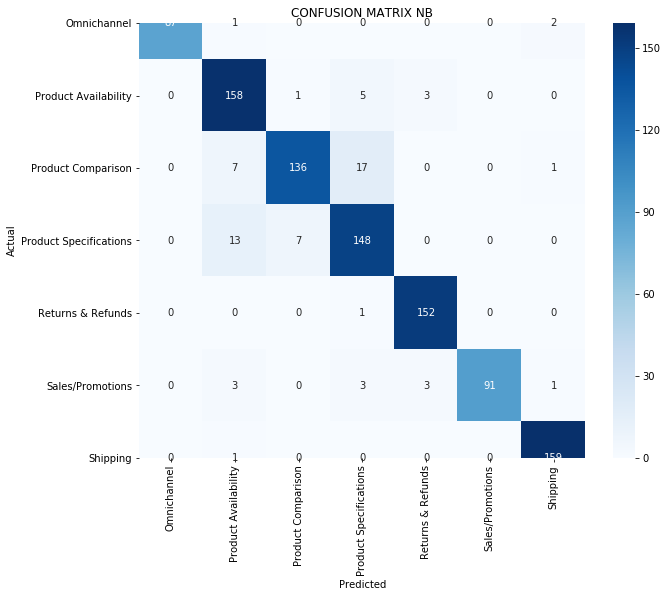

In [34]:
matrix = confusion_matrix(test_y, pred_y)
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels = topics, yticklabels = topics)
plt.ylabel('Actual', rotation = 90)
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX NB")
plt.show()

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 7. Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
grid_params ={
 'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 50, 60, 70, 80,90]
}

clf = RandomizedSearchCV(RandomForestClassifier(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

C:\Users\samrat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:  0.8815
Best Params:  {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [23]:
# Trying above params on Random Forest (Bagging Model): Word-Level n-gram TF-IDF
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier=RandomForestClassifier(n_estimators= 50, 
                                              min_samples_split= 2, 
                                              min_samples_leaf= 2, 
                                              max_features= 'auto', 
                                              max_depth= None, 
                                              bootstrap= False,random_state = 42)
RandomForestClassifier.fit(xtrain_tfidf,train_y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Metrics

In [24]:
pred_y1 = RandomForestClassifier.predict(xtest_tfidf)
print('               classification_report\n',classification_report(test_y, pred_y1))

               classification_report
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        90
           1       0.92      0.81      0.86       167
           2       0.99      0.76      0.86       161
           3       0.65      0.96      0.78       168
           4       0.99      0.98      0.99       153
           5       0.99      0.84      0.91       101
           6       0.99      0.99      0.99       160

    accuracy                           0.90      1000
   macro avg       0.94      0.90      0.91      1000
weighted avg       0.92      0.90      0.90      1000



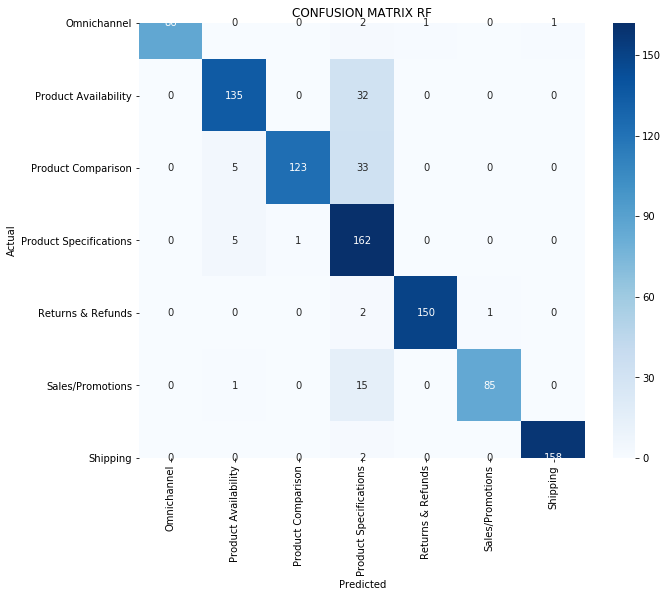

In [35]:
matrix = confusion_matrix(test_y, pred_y1)
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels = topics, yticklabels = topics)
plt.ylabel('Actual', rotation = 90)
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RF")
plt.show()

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 8. Neural Network Classifier

In [26]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 500, n_iter = 7, random_state = 42)
X_train_nn=svd.fit_transform(xtrain_tfidf)
X_test_nn=svd.transform(xtest_tfidf)

In [27]:
from sklearn.datasets import fetch_20newsgroups
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from sklearn import metrics
def DNN(shape, nClasses):
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    dropout = 0.25
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
model_DNN = DNN(X_train_nn.shape[1], 7)
model_DNN.fit(X_train_nn, train_y,
                              validation_split=0.2,
                              epochs=10,
                              batch_size=32,
                              verbose=2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
 - 2s - loss: 1.4130 - accuracy: 0.4178 - val_loss: 0.8011 - val_accuracy: 0.6525
Epoch 2/10
 - 2s - loss: 0.5200 - accuracy: 0.7781 - val_loss: 0.3985 - val_accuracy: 0.8438
Epoch 3/10
 - 2s - loss: 0.2957 - accuracy: 0.8834 - val_loss: 0.3146 - val_accuracy: 0.8813
Epoch 4/10
 - 2s - loss: 0.2429 - accuracy: 0.9097 - val_loss: 0.3045 - val_accuracy: 0.8850
Epoch 5/10
 - 2s - loss: 0.2229 - accuracy: 0.9100 - val_loss: 0.2829 - val_accuracy: 0.8963
Epoch 6/10
 - 2s - loss: 0.1984 - accuracy: 0.9241 - val_loss: 0.2774 - val_accuracy: 0.9000
Epoch 7/10
 - 2s - loss: 0.1841 - accuracy: 0.9284 - val_loss: 0.2785 - val_accuracy: 0.9137
Epoch 8/10
 - 2s - loss: 0.1476 - accuracy: 0.9431 - val_loss: 0.2479 - val_accuracy: 0.9175
Epoch 9/10
 - 2s - loss: 0.1573 - accuracy: 0.9419 - val_loss: 0.3010 - val_accuracy: 0.9075
Epoch 10/10
 - 2s - loss: 0.1985 - accuracy: 0.9303 - val_loss: 0.3793 - val_accuracy: 0.9075


In [32]:
pred_y2 = model_DNN.predict_classes(X_test_nn)

## Metrics

In [33]:
print('               classification_report\n',classification_report(test_y, pred_y2))

               classification_report
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        90
           1       0.74      0.95      0.83       167
           2       0.85      0.75      0.79       161
           3       0.83      0.77      0.80       168
           4       0.99      0.99      0.99       153
           5       0.98      0.87      0.92       101
           6       0.98      0.98      0.98       160

    accuracy                           0.89      1000
   macro avg       0.91      0.89      0.90      1000
weighted avg       0.90      0.89      0.89      1000



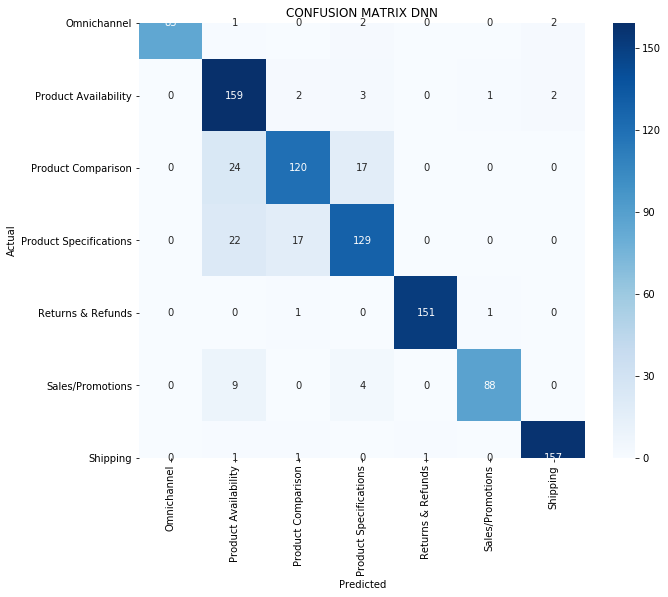

In [36]:
matrix = confusion_matrix(test_y, pred_y2)
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels = topics, yticklabels = topics)
plt.ylabel('Actual', rotation = 90)
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX DNN")
plt.show()

## Comparision on above 3 metrics

In [37]:
print('          NB     classification_report\n',classification_report(test_y, pred_y))
print('          RF     classification_report\n',classification_report(test_y, pred_y1))
print('          NN     classification_report\n',classification_report(test_y, pred_y2))

          NB     classification_report
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.86      0.95      0.90       167
           2       0.94      0.84      0.89       161
           3       0.85      0.88      0.87       168
           4       0.96      0.99      0.98       153
           5       1.00      0.90      0.95       101
           6       0.98      0.99      0.98       160

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.93      0.93      0.93      1000

          RF     classification_report
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        90
           1       0.92      0.81      0.86       167
           2       0.99      0.76      0.86       161
           3       0.65      0.96      0.78       168
           4       0.99      0.98      0.99       15

In [ ]:
#High accuracy, precision & recall is achieved by MultinomialNB. Let's carry out an out of sample test and confirm.

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>

## 9. Out of Sample Test

In [68]:
text = ["I am so upset with this product I want full refund"]
text_tfidf = tfidf_vect.transform(text)
NB_Pred = MultinomialNB.predict(text_tfidf)
RF_Pred = RandomForestClassifier.predict(text_tfidf)
DNN_Pred = model_DNN.predict_classes(svd.transform(text_tfidf))

In [69]:
topics

array(['Omnichannel', 'Product Availability', 'Product Comparison',
       'Product Specifications', 'Returns & Refunds', 'Sales/Promotions',
       'Shipping'], dtype=object)

In [70]:
print('Naivebayes outcome :',topics[NB_Pred[0]])
print('Random Forest outcome :',topics[RF_Pred[0]])
print('Neural network outcome :',topics[DNN_Pred[0]])

Naivebayes outcome : Returns & Refunds
Random Forest outcome : Product Specifications
Neural network outcome : Returns & Refunds


In [71]:
#Random Forest couldn't predict even when I clearly mentioned the word 'refund'. 
#I'm thinking of a way to add topic names to BOW and have more more weight to them. 
#That way atleast the input containing clear mention would be predicted correctly. 

# <center>THANK YOU</center> 

## Failed wandb implementation for tuning Hyperparameters

In [80]:
import wandb
wandb.login()  #it asks to enter API but I've previously entered it

True

In [81]:
#defining sweep 

sweep_config = {
    'method': 'random'
    }

In [82]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [83]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [84]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

In [85]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

In [86]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [87]:
#Initialize the sweep

sweep_id = wandb.sweep(sweep_config, project="trying-sweeps")

Create sweep with ID: wv3asgka
Sweep URL: https://wandb.ai/samratkorupolu/trying-sweeps/sweeps/wv3asgka


https://wandb.ai/samratkorupolu/pytorch-sweeps-demo/sweeps/t3bos2y3?workspace=user-samratkorupolu

In [ ]:
#I haven't read full documentation of WandB but it's a really cool way of looking what's happening inside hidden layers

<a href= "#A4.-Customer-Service-Query-Classification">Back to Top</a>